# Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns

from network import Net
from diff_equation import *

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()
np.random.seed(10)

In [2]:
print(np.__version__)

1.26.4


# Training Data

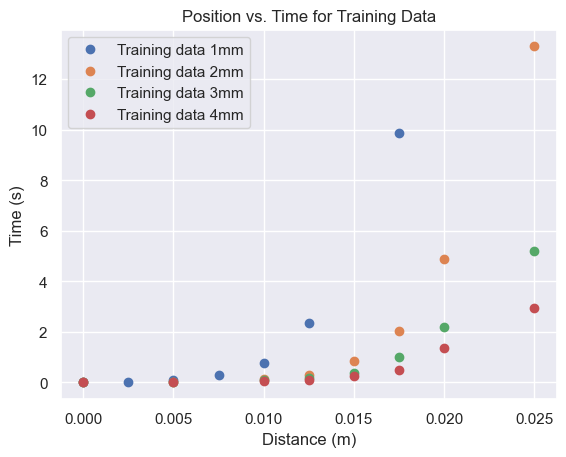

In [3]:
# Grab training data
dim_data = grab_training_data(real = True)

# Define legends for dimensionalized data
dim_legend = ['Training data 1mm', 'Training data 2mm', 'Training data 3mm', 'Training data 4mm']

# Functions to plot dimensionalized and nondimensionalized data
def plot_dim_data(show=True):
    for i in range(0, len(dim_data)):
        plt.plot(dim_data[i]['DISTANCE'], dim_data[i]['TIME'], 'o')
    plt.legend(dim_legend)
    plt.ylabel('Time (s)')
    plt.xlabel('Distance (m)')
    plt.title('Position vs. Time for Training Data')
    if show:
        plt.show()

# Plot dimensionalized training data
plot_dim_data()

# Run the Model

Losses for 1mm droplet:
Epoch 1/20000, data loss: 14451.3046875, physics loss: 4222101.5
Epoch 2/20000, data loss: 14443.5, physics loss: 4222100.0
Epoch 3/20000, data loss: 14435.689453125, physics loss: 4222098.0
Epoch 4/20000, data loss: 14427.892578125, physics loss: 4222096.0
Epoch 5/20000, data loss: 14420.1171875, physics loss: 4222094.5
Epoch 6/20000, data loss: 14412.35546875, physics loss: 4222093.0
Epoch 7/20000, data loss: 14404.6083984375, physics loss: 4222090.5
Epoch 8/20000, data loss: 14396.86328125, physics loss: 4222089.5
Epoch 9/20000, data loss: 14389.115234375, physics loss: 4222087.5
Epoch 10/20000, data loss: 14381.361328125, physics loss: 4222086.0
Epoch 2000/20000, data loss: 704.5942993164062, physics loss: 20246.380859375
Epoch 4000/20000, data loss: 804.1983032226562, physics loss: 2938.501953125
Epoch 6000/20000, data loss: 769.1517944335938, physics loss: 1132.1912841796875
Epoch 8000/20000, data loss: 801.4995727539062, physics loss: 587.3710327148438
Ep

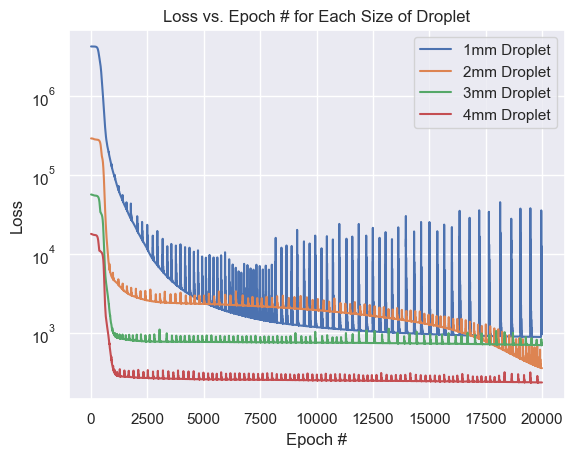

In [4]:
plt.yscale('log')
different_droplet_networks = [None] * len(dim_data)

'''
Train model for each droplet size, plot losses for each one.
Change the bounds on this loop and subsequent ones from '0', 'len(different_droplet_networks)' to '0', '1' to do only the 1mm droplet.
You can change the bounds similarly to only train the network for other-sized droplets.
'''
for i in range(0, len(different_droplet_networks)):
# for i in range(0, 1):
    different_droplet_networks[i] = Net(1, 1, droplet_size_idx=i, loss2=physics_loss_dim, epochs=20000, loss1_weight=1000, loss2_weight=1, lr=1e-4).to(DEVICE)
    print(f'Losses for {i+1}mm droplet:')
    losses = different_droplet_networks[i].fit(np.array(dim_data[i]['DISTANCE']), np.array(dim_data[i]['TIME']))
    print()
    plt.plot(losses)
plt.legend(['1mm Droplet', '2mm Droplet', '3mm Droplet', '4mm Droplet'])
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch # for Each Size of Droplet')
plt.show()

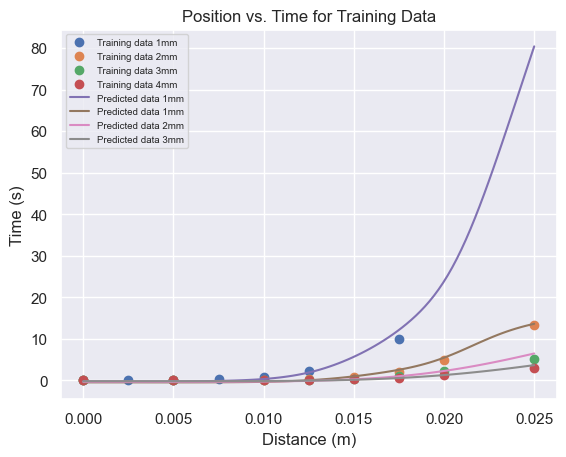

In [8]:
'''
Plot the dimensionalized data for each droplet as well as each respective dimensionalized model
'''

# Plot dimensionalized data
plot_dim_data(show=False)

# Use nondimensionalized model to make prediction
xs = np.linspace(0, 0.025, 100)

# Plot dimensionalized model
for i in range(0, len(different_droplet_networks)):
# for i in range(0, 1):
    preds = different_droplet_networks[i].predict(xs)
    plt.plot(xs, preds)
    dim_legend.append(f'Predicted data {i+1}mm')
plt.legend(dim_legend, fontsize=7)
plt.show()



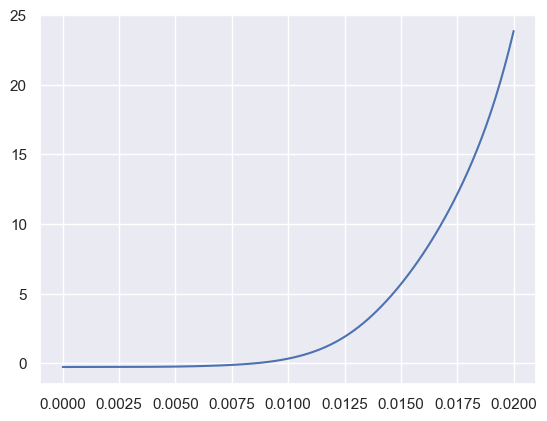

In [6]:
pred = different_droplet_networks[0].predict(xs)
plt.plot(xs, pred)
plt.show()